# Implementing Geospatial Calculations on the EVM using Linearized Approximations

The implementation of mathemematical formulas in EVM programming languages such as solidity is difficult and uninutitive due to the lack of floating points. Additionally, contracts might rely on libraries for functions that are deprecated, or insecure. This article will present a method to implement any mathematical function on an EVM smart contract, with the ultimate purpose of creating a framework for geospatial calculations within a smart contract.

# Problem

Let's say we have a restricted airspace with its location recorded on a smart contract. We want to determine if a plane is near the airspace and is bearing towards it. Currently, we don't have a way to determine the bearing on chain.

This process requires an implementation of the arctangent function. As far as I am aware, there is no implementation of arctangent available for use. However, this linearization process will allow us to implement arctangent in this contract in a secure and accurate way.

# Applications

This method works best for applications where implementing the original function is too complex, or impossible. Potential use cases include:


*   Sine and Cosine
*   Haversine formula
*   Square Root Function
*   Calculating the compass bearing between two points





# Description

Using only an elementary understanding of linear algebra, any complex polynomial or function, such as e^x or log(x) can be approximated by a series of linear lines. The program descibes below allows you to do just that. First, it  returns two arrays, one for the slopes of each line, and another for the intercepts of each line. Then, to evaluate your function at any point, simply select the index associated with value you would like to evaluate, which is just a point along the function's curve, use the index to select the slope and intercept for the associated point, multiply your value by the corresponding slope, and, finally, add the corresponding intercept.

# Are there limitations?

Yes, inherently there are limitations when using an approximation of a function, rather than the function itself. However, to achieve the desired precision, you need only to increase the number of lines used. For equations with a derivative whose range is [-1,1], increasing the number of lines used becomes increasingly necessary.

# Potential Expansions

This general methodology can be expanded beyond for uses in other specific scenarios. For 3 dimensional surfaces that take two variables as parameters, one can construct planes to approximate the function instead of lines. Additionally, if a function is very curvy, one can construct a series of polynomials to approximate the function, instead of just lines.

# Python Imports

In [17]:
import numpy as np
import math as m
import pandas as pd
from sympy import symbols, Eq
import matplotlib.pyplot as plt
import csv

# Define a Function

This block will be the function we are linearizing. This can be any function supported by numpy, but for the purposes of this article, we will use sine

In [24]:
def fn(x):
  return np.sin(x)

# Linearization

This code block will generate the lookup table necessary. The function takes in four inputs: 'eq': the equation you wishto linearize, 'x_min', the leftmost bound of the x-axis, 'x_max': the rightmost bound of the x axis, and 'buckets': the number of subdivisions.

In [25]:
def valueGen(eq, x_min, x_max, buckets):
    x = []
    step = float((x_max - x_min) / buckets)

    for i in range(buckets + 1):
        x.append(x_min + i * step)

    y = [eq(val) for val in x]
    return {"x": x, "y": y, "step": step}

This code block will generate the individual linearized functions which make up the larger function. These are stored as two arrays, 'slopes': which contains the slopes of each line, and 'intercepts': which contains the intercepts of each line.

In [26]:
def linearize(X,Y):
  slopes = []
  intercepts = []

  for i, x in enumerate(X):
    if(i == len(X)-1):
      break
    slopes.append((Y[i+1] - Y[i])/(X[i+1] - x))
    intercepts.append(Y[i] - slopes[i]*x)

  return {"slopes": slopes,"intercepts":intercepts}

This code block allows you to evaluate a point in your linearized function in python. This can be helpful for sanity checks, or by checking against your solidity implementation. The function takes in the two arrays generated by the previous block 'slopes' and 'intercepts', as well as 'x_min': the leftmost bound of the x axis, 'buckets': the number of subdivisions, and 'value': the point you wish to evaluate.

In [27]:
def evaluate(slopes,intercepts,x_min,step,value):
  idx = int((value-x_min)/step)
  if idx > len(slopes)-1:
    idx = len(slopes)-1
  slope = slopes[idx]
  intercept = intercepts[idx]

  return slope*value+intercept

This code block evaluates the linearized function at every point within the range. It can be useful for plotting as we'll see below.

In [28]:
def linearizer(eq,x_min,x_max,buckets):
  values = valueGen(eq,x_min,x_max,buckets)
  weights = linearize(values['x'],values['y'])
  x = np.linspace(x_min,x_max,100)
  y = [evaluate(weights['slopes'],weights['intercepts'],x_min,values['step'],x) for x in x]
  return {'x':x,'y':y}

# Example

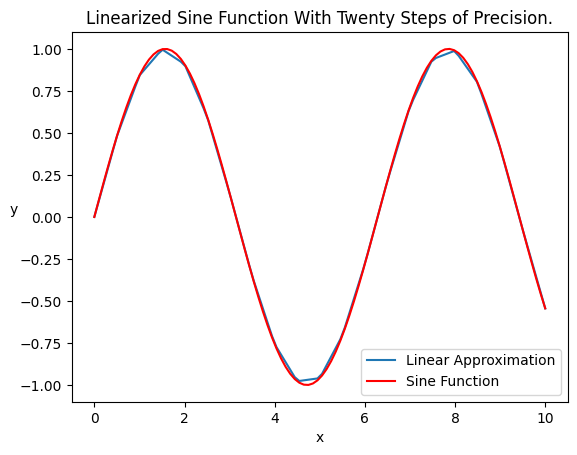

In [35]:
output = linearizer(fn,0,10,20)
df = pd.DataFrame.from_dict(output)

x_values = np.linspace(0, 10, 100)
y_values = np.sin(x_values)

df.plot(x = 'x',y = 'y', label='Linear Approximation')
plt.plot(x_values, y_values, color='red', label='Sine Function')
plt.title('Linearized Sine Function With Twenty Steps of Precision.')
plt.xlabel('x')
plt.ylabel('y', rotation = 0)
plt.legend()
plt.show()

# Implementation in Solidity

This function takes 5 inputs, 'eq': the equation defined by the block above that you aim to linearize, 'x_min': the leftmost bound on the x axis, 'x_max': the rightmost bound on the x axis, 'buckets': the number of subdivisions you want, and 'decnum': the level of integer precision desired.

This logic will evaluate the function at each segment and calculate the corresponding line, which is represented by the slope and intercept. These values are stored and returned in two arrays: 'large_slopes', and 'large_intercepts.'

In [46]:
def soliditylinearizer(eq, x_min, x_max, buckets, decnum):
    values = valueGen(eq, x_min, x_max, buckets)
    weights = linearize(values['x'], values['y'])
    x = np.linspace(x_min, x_max, 100)
    y = [(evaluate(weights['slopes'], weights['intercepts'], x_min, values['step'], x) * (decnum)) for x in x]
    large_slopes = [slope * (decnum) for slope in weights['slopes']]
    large_intercepts = [round(intercept, 10) * (decnum) for intercept in weights['intercepts']]
    return {'x': x, 'y': y, 'large_slopes': large_slopes, 'large_intercepts': large_intercepts}

This code block allows you to evaluate a point using the solidity implenetation of your linearized function in python. This can be helpful for sanity checks, or by checking against the above implementation.

The function takes in the two arrays generated by the previous block 'slopes' and 'intercepts', as well as 'x_min': the leftmost bound of the x axis, 'buckets': the number of subdivisions, and 'value': the point you wish to evaluate.

In [47]:
def solidity_evaluate(large_slopes, large_intercepts, x_min, x_max, buckets, decnum, value):
    step = (x_max-x_min)/buckets
    idx = int((value-x_min)/step)
    if idx > len(large_slopes)-1:
        idx = len(large_slopes)-1
    large_slope = large_slopes[idx]
    large_intercept = large_intercepts[idx]

    return (large_slope * value + large_intercept) / (decnum)

To implement our linearization in Solidity, we can use the following code block to generate a csv file of our arrays of slopes and intercepts. The csv is formatted in such a way that you can easily open it, and copy and paste the values into an array in your solidity contract, without the need to add commas.

In [38]:
def write_to_csv(large_slopes, large_intercepts, filename):
    with open(filename, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(['Large Slopes', 'Large Intercepts'])

        for i in range(len(large_slopes)):
            slope_str = f'int256({int(large_slopes[i])}),'
            intercept_str = f'int256({int(large_intercepts[i])}),'
            csv_writer.writerow([slope_str, intercept_str])

# Solidity Example Graph

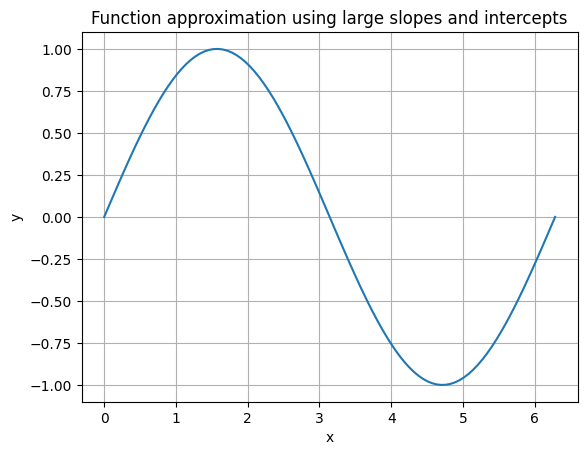

In [51]:
output = soliditylinearizer(fn, 0, 2*np.pi, 100, 1000)
large_slopes = output['large_slopes']
large_intercepts = output['large_intercepts']
x_min = 0
x_max = 2*np.pi
buckets = 100
decnum = 1000

x = np.linspace(x_min, x_max, 100)
y = [solidity_evaluate(large_slopes, large_intercepts, x_min, x_max, buckets, decnum, x_value) for x_value in x]

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function approximation using large slopes and intercepts')
plt.grid(True)
plt.show()

# Example Evaluation

In [53]:
output = soliditylinearizer(fn, 0, 2*np.pi, 100, 1000)
large_slopes = output['large_slopes']
large_intercepts = output['large_intercepts']
x_min = 0
x_max = 2*np.pi
buckets = 100
decnum = 1000

print(f'The value of the sine function at x=2 is: {np.sin(2)}')
print(f'The value of the linearized sine function at x=2, with 100 buckets of precision is: {solidity_evaluate(large_slopes, large_intercepts, x_min, x_max, buckets, decnum, 2)}')

The value of the sine function at x=2 is: 0.9092974268256817
The value of the linearized sine function at x=2, with 100 buckets of precision is: 0.9090437907019319
